In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt

import SearchingOptimalEnsembles.metadatasets.quicktune.metadataset as qmd
import SearchingOptimalEnsembles.metadatasets.scikit_learn.metadataset as slmd
try: 
    import SearchingOptimalEnsembles.metadatasets.tabrepo.metadataset as trmd
except ImportError:
    trmd = None
import SearchingOptimalEnsembles.metadatasets.nasbench201.metadataset as nbmd

from SearchingOptimalEnsembles.posthoc.neural_ensembler import NeuralEnsembler
from sklearn.metrics import f1_score



In [3]:
DATA_DIR = "/work/dlclarge2/janowski-quicktune/predictions"
md_class = qmd.QuicktuneMetaDataset
metric_name = "error"
data_version = "micro"
task_id = 0

metadataset = md_class(
    data_dir=DATA_DIR, metric_name=metric_name, data_version=data_version
)
dataset_names = metadataset.get_dataset_names()

metadataset.set_state(dataset_names[task_id])


In [20]:
dropout_rate = 0.
ne = NeuralEnsembler(metadataset=metadataset,
                        ne_add_y=True,
                        ne_use_context=True,
                        learning_rate=0.0001,
                        epochs=1000,
                        ne_reg_term_div=0.0,
                        ne_reg_term_norm=0.,
                        ne_num_layers=3,
                        ne_num_heads=1,
                        ne_context_size=256,
                        ne_hidden_dim=32,
                        ne_use_mask=True,
                        ne_eval_context_size=128,
                        ne_resume_from_checkpoint=False,
                        ne_unique_weights_per_function=False,
                        ne_dropout_rate=dropout_rate,
                        use_wandb=False,
                        ne_net_type="ffn")

X_obs = [i.item() for i in metadataset.hp_candidates_ids]

best_ensemble, best_metric = ne.sample(X_obs)
weights = ne.get_weights(X_obs)

/home/pineda/SearchingOptimalEnsembles/SearchingOptimalEnsembles/posthoc/neural_ensembler.py:430: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long)


Epoch 0 Loss 1.3989604711532593 Div Loss -0.0018321501556783915 W: 0.0002158642455469817
Epoch 1 Loss 1.3986485004425049 Div Loss -0.0018321495736017823 W: 0.0002158314164262265
Epoch 2 Loss 1.3983341455459595 Div Loss -0.0018321489915251732 W: 0.00021579790336545557
Epoch 3 Loss 1.398015022277832 Div Loss -0.0018321482930332422 W: 0.0002157624257961288
Epoch 4 Loss 1.3976917266845703 Div Loss -0.0018321475945413113 W: 0.00021572639525402337
Epoch 5 Loss 1.3973658084869385 Div Loss -0.0018321470124647021 W: 0.00021569087402895093
Epoch 6 Loss 1.3970377445220947 Div Loss -0.0018321463139727712 W: 0.00021566332725342363
Epoch 7 Loss 1.3967081308364868 Div Loss -0.0018321456154808402 W: 0.00021566275972872972
Epoch 8 Loss 1.3963781595230103 Div Loss -0.0018321449169889092 W: 0.00021564902272075415
Epoch 9 Loss 1.3960481882095337 Div Loss -0.0018321441020816565 W: 0.00021560979075729847
Epoch 10 Loss 1.3957183361053467 Div Loss -0.0018321432871744037 W: 0.00021556219144258648
Epoch 11 Loss

In [21]:
weights.shape

torch.Size([1, 230, 160, 20])

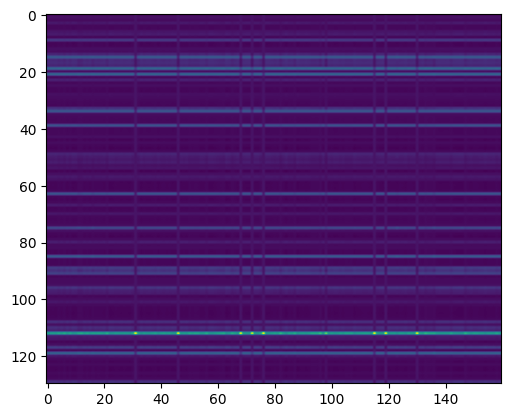

In [22]:
a = weights[0,100:,...,0]
plt.imshow((a-a.mean(0))/a.std(0))

In [23]:
predictions = metadataset.get_predictions([X_obs])
y_true = metadataset.get_targets().numpy()


In [24]:
f1_scores = []
for i in range(predictions.shape[1]):

    y_pred = predictions[0][i].argmax(-1).numpy()
    f1_scores.append(f1_score(y_true, y_pred, average=None))
f1_scores = np.array(f1_scores)


tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)


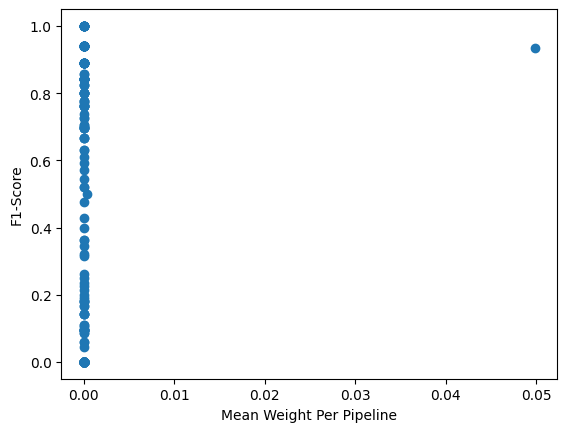

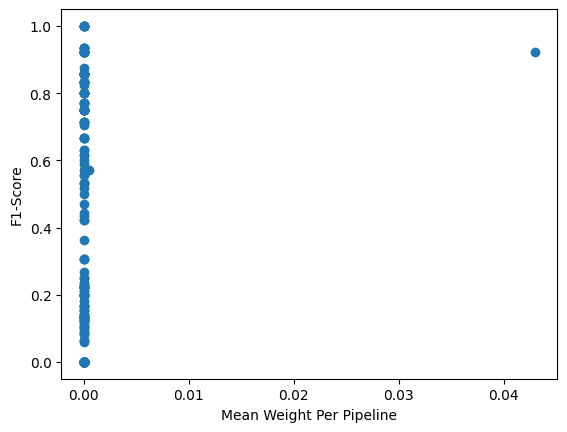

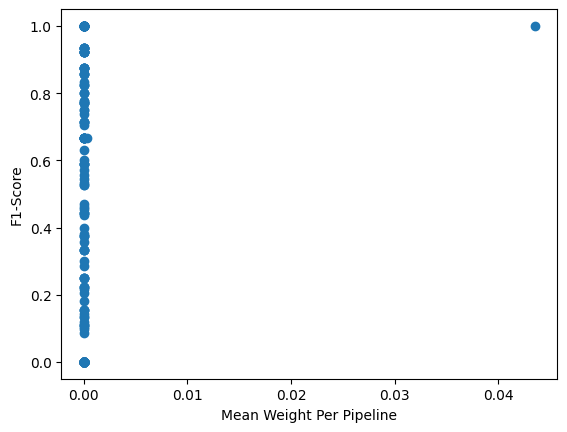

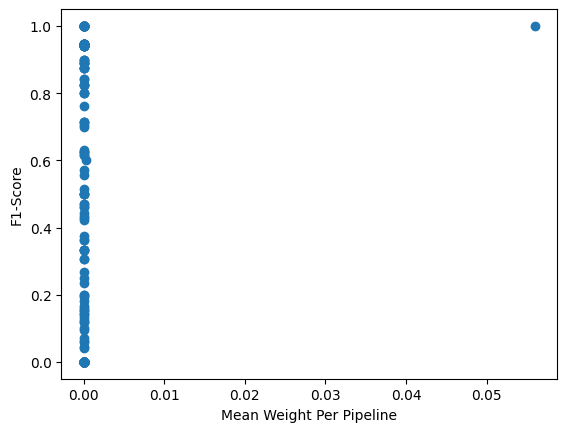

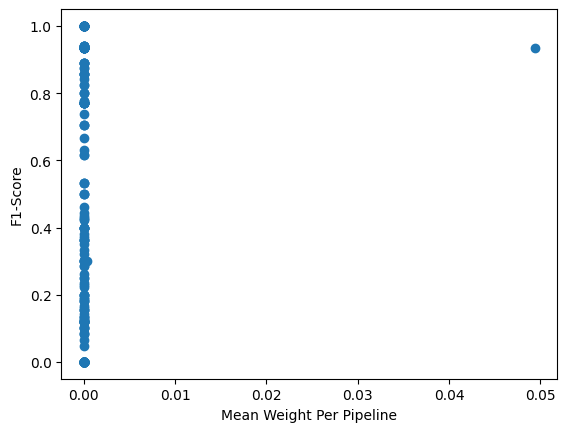

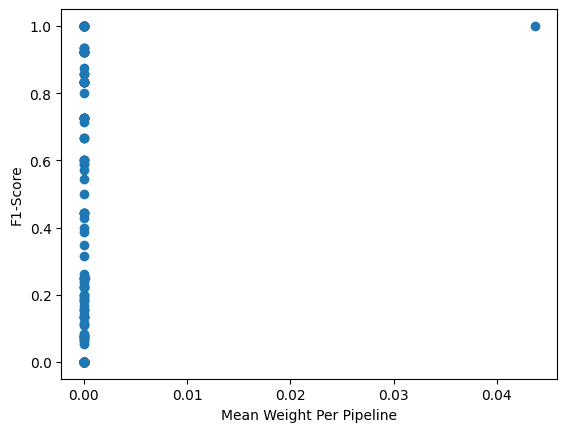

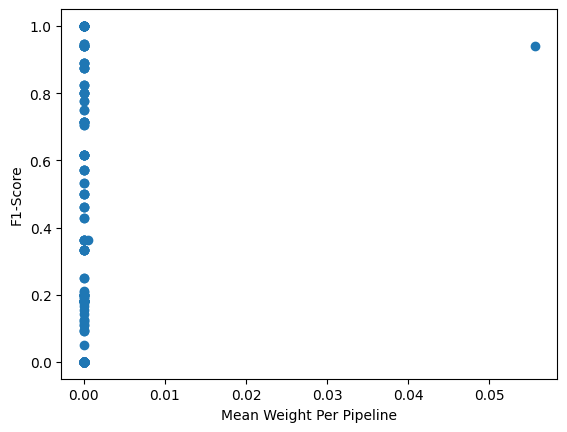

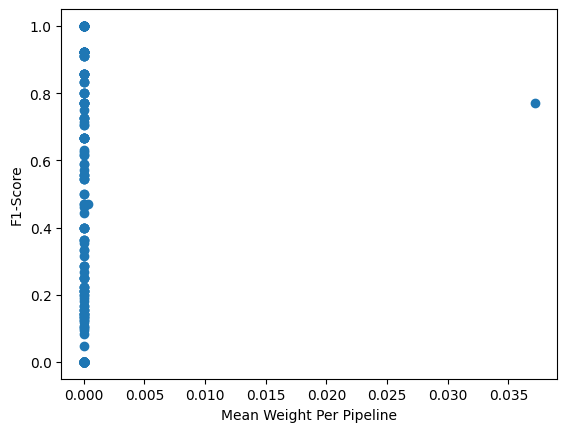

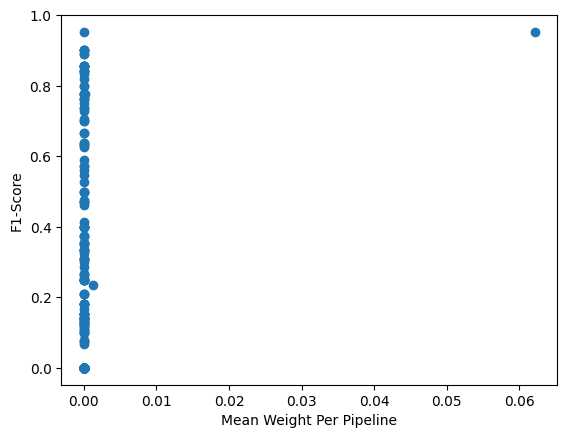

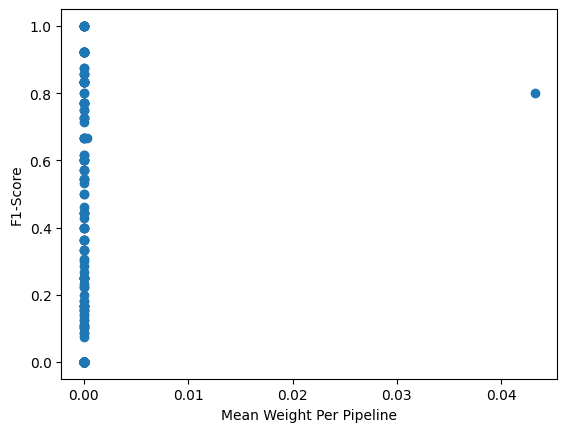

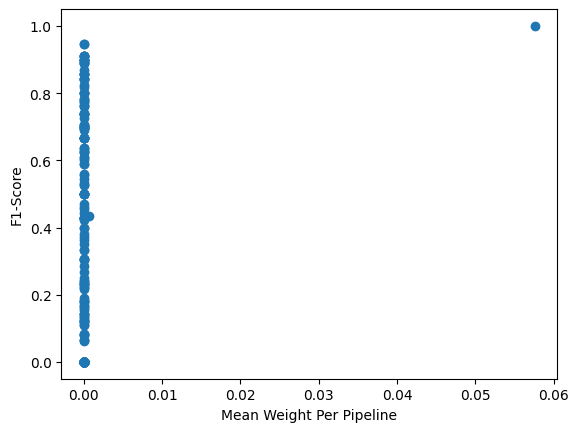

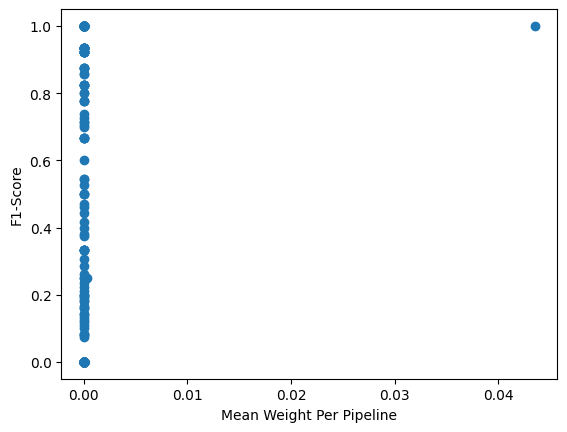

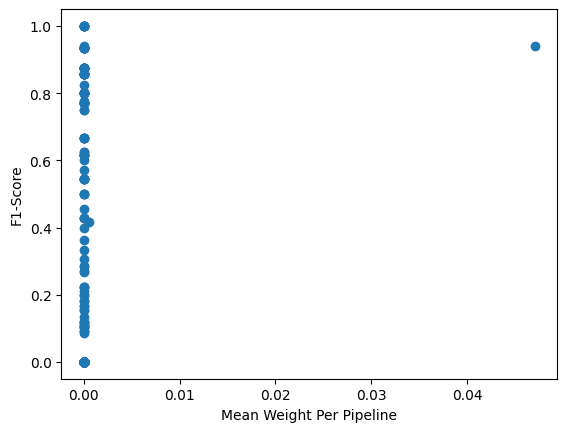

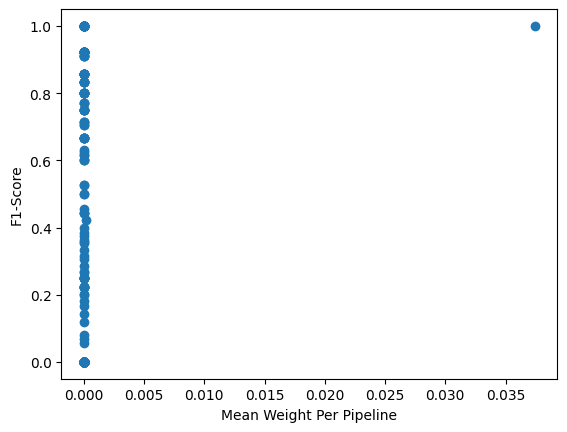

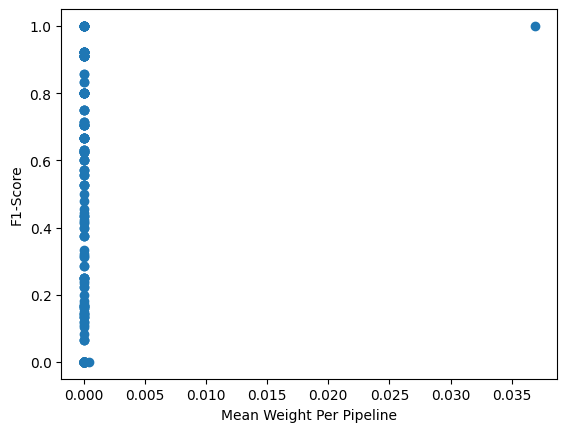

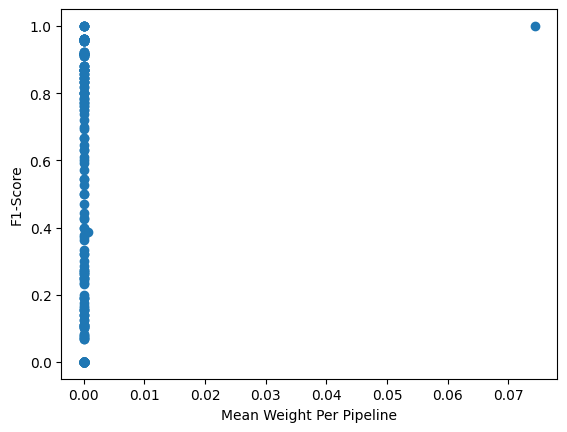

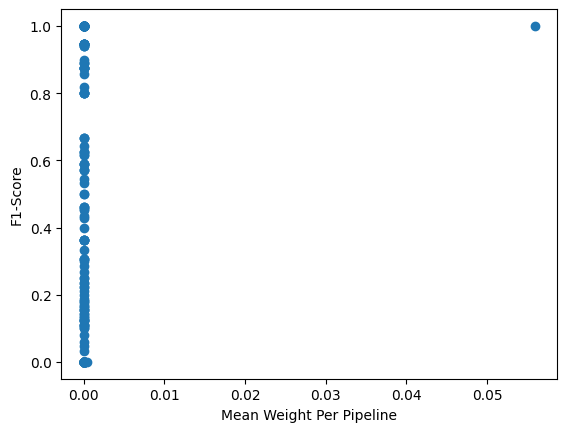

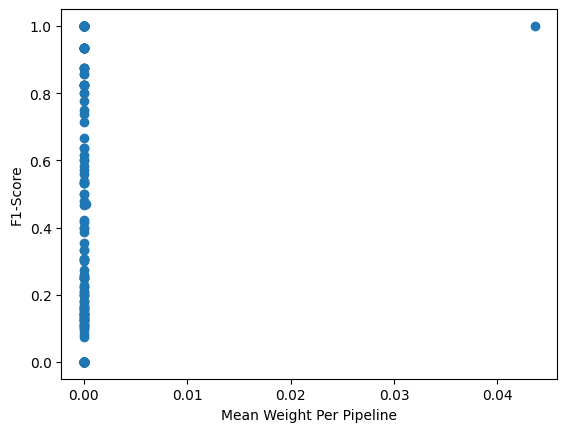

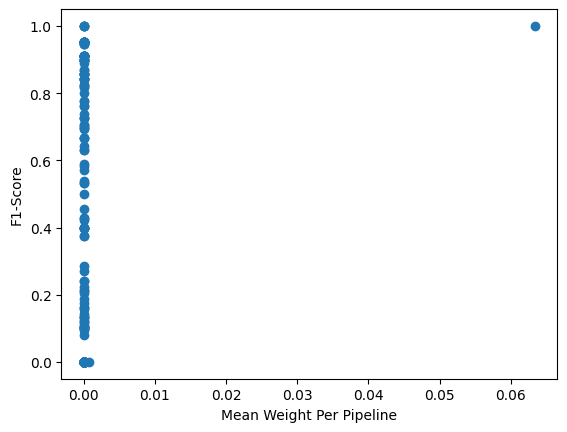

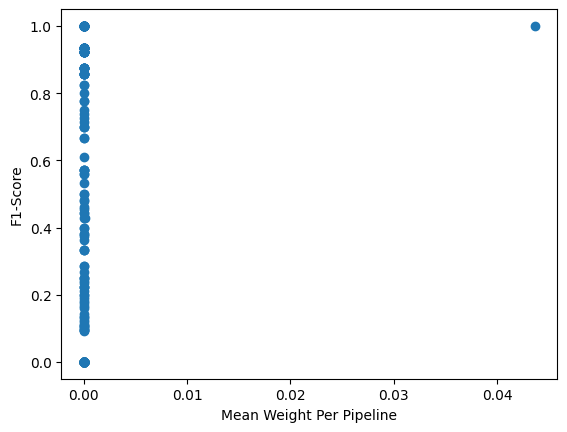

In [25]:

for i in range(f1_scores.shape[1]):
    x = weights[0].mean(axis=-2)[:,i]
    print(((x-x.mean())>x.std()).sum())
    plt.figure()
    plt.scatter(weights[0].mean(axis=-2)[:,i],f1_scores[:,i])
    plt.xlabel("Mean Weight Per Pipeline")
    plt.ylabel("F1-Score")

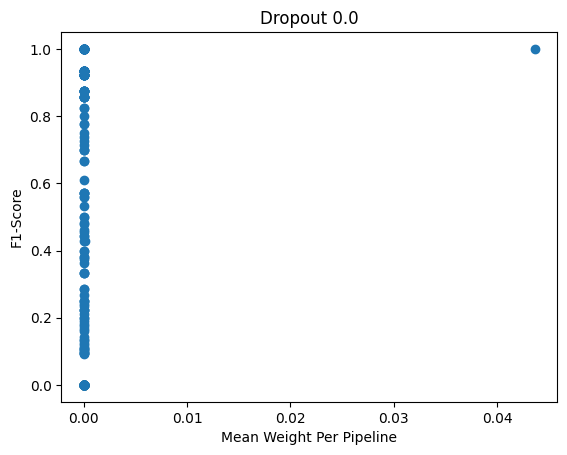

In [26]:
plt.scatter(weights[0].mean(axis=-2)[:,i],f1_scores[:,i])
plt.xlabel("Mean Weight Per Pipeline")
plt.ylabel("F1-Score")
plt.title(f"Dropout {dropout_rate}")
plt.savefig("saved_plots/hypothesis_overfitting3.png")

In [49]:
weights[0][...,i].shape

torch.Size([230, 160])

In [45]:
weights[0].shape

torch.Size([230, 160, 20])